Generating mock market data...

ANALYSIS LEVEL SELECTION

THREE ANALYSIS MODES:

1. SINGLE ORDER MODE
   Purpose: Diagnose specific execution problems
   Use when: Reviewing a particular problematic order
   Sample size: 1 order (20-60 waves typically)
   Limitation: Low statistical power, hard to separate signal from noise
   
2. AGGREGATE MODE (RECOMMENDED)
   Purpose: Detect systematic footprint in your strategy
   Use when: Evaluating overall execution quality
   Sample size: 10-200+ orders (hundreds of waves)
   Benefit: High statistical power, reveals strategy-level patterns
   
3. BOTH MODE
   Purpose: Comprehensive analysis - aggregate trends + individual outliers
   Use when: Deep-dive analysis or strategy optimization
   Sample size: 10-200+ orders with per-order breakdown
   Output: Aggregate metrics + individual order scores

RECOMMENDATION: Start with AGGREGATE mode for 50+ orders.
                Only drill into SINGLE orders if aggregate shows footprint.


Selected Mode:

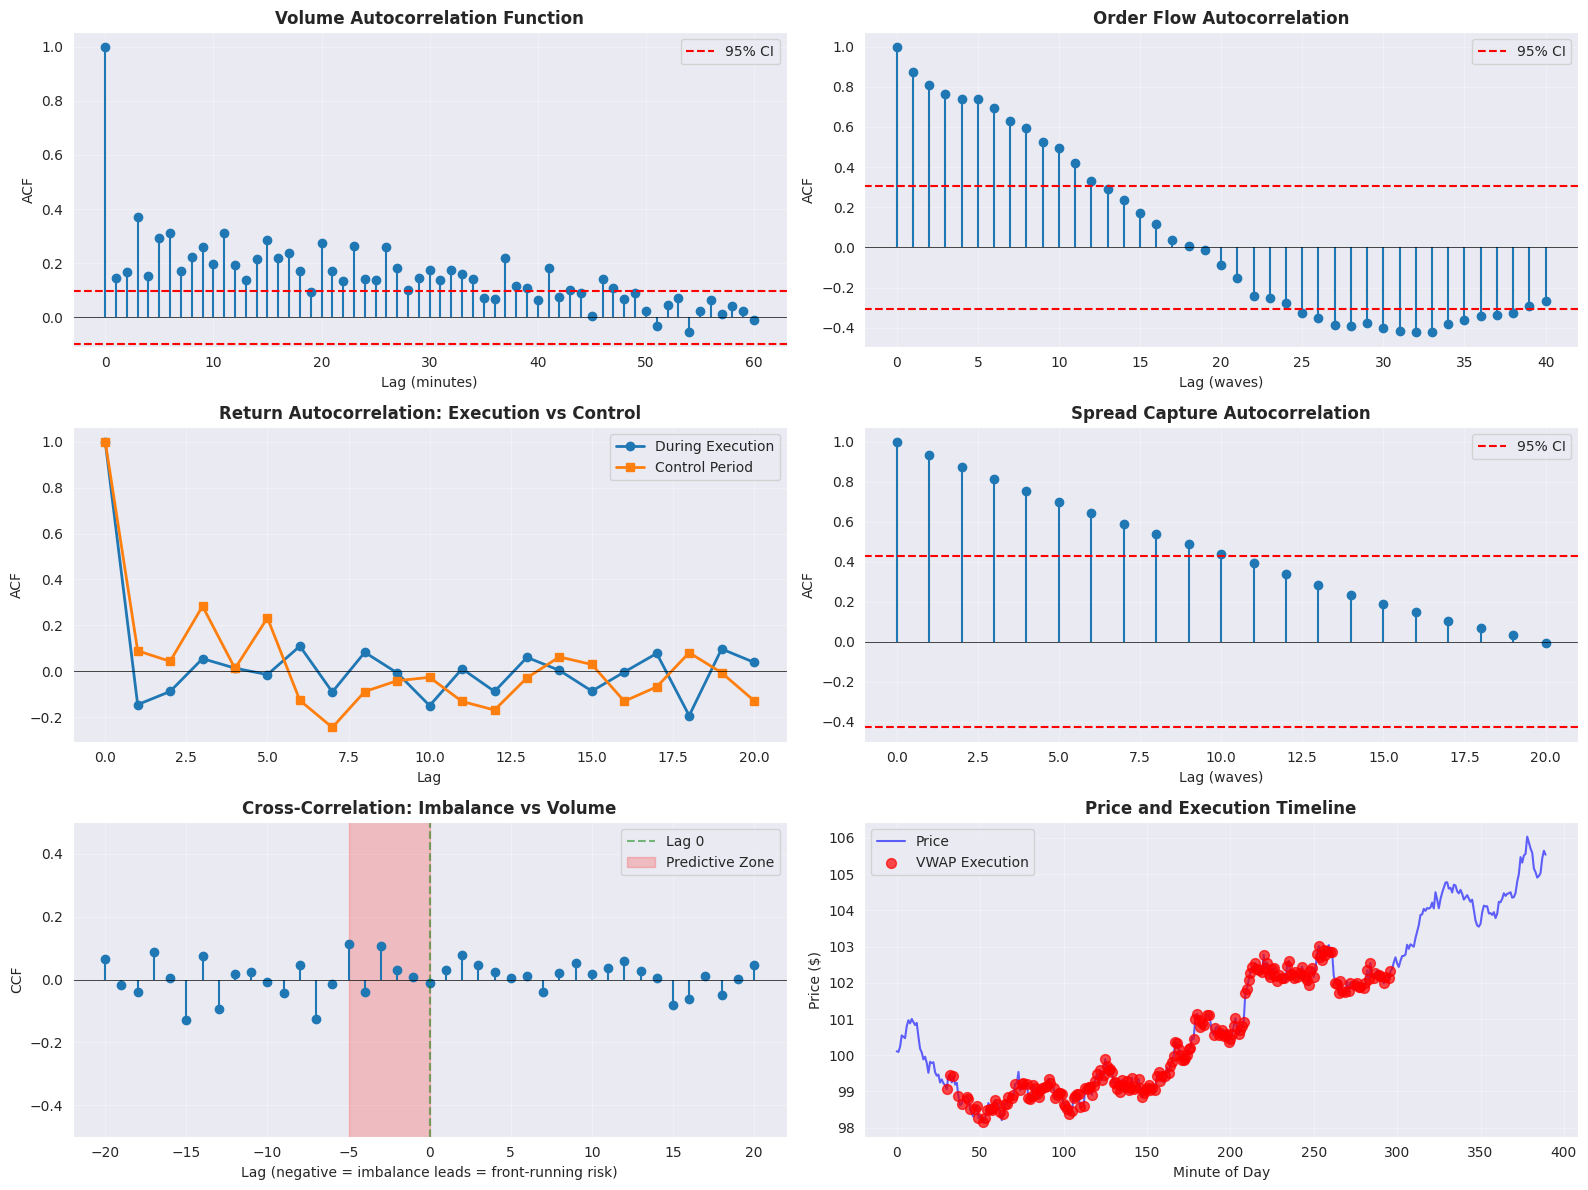


Analysis complete! Chart saved as 'vwap_footprint_analysis.png'

FOOTPRINT RISK SCORE

Overall Score: 50/100
Based on: 10 parent order(s), 1115 fills

Detected Indicators:
  1. Volume clustering detected
  2. Persistent directional flow

⚡ MODERATE FOOTPRINT RISK - Monitor execution patterns

NEXT STEPS FOR PRODUCTION:

1. DATA COLLECTION STRATEGY (kdb queries):
   ----------------------------------------
   AGGREGATE ANALYSIS (Primary - Run Weekly/Monthly):
   • Query 50-200+ parent orders over time period
   • Pool all waves together for statistical power
   • Calculate ACF on aggregated time series
   • Example kdb: 
     exec_data: select from executions where date within (start_date;end_date)
     
   INDIVIDUAL ANALYSIS (Diagnostic - Run As Needed):
   • Query specific problematic orders
   • Calculate per-order footprint scores
   • Compare to aggregate benchmark
   • Example kdb:
     order_data: select from executions where parent_order_id=`PO_12345

2. RECOMMENDED WORKFLOW:


In [3]:
"""
VWAP Order Footprint Detection using Autocorrelation
Mock data implementation - replace with kdb queries for production
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from datetime import datetime, timedelta

# Set style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (15, 10)

# ============================================================================
# SECTION 1: MOCK DATA GENERATION
# ============================================================================
# In production, replace this section with kdb queries

def generate_mock_market_data(n_minutes=390, seed=42):
    """
    Generate mock intraday market data
    In production: Replace with kdb query for TAQ data
    """
    np.random.seed(seed)

    # Trading day from 9:30 to 16:00 (390 minutes)
    times = pd.date_range('2024-01-15 09:30', periods=n_minutes, freq='1min')

    # Base price with drift and volatility
    returns = np.random.normal(0.0001, 0.002, n_minutes)
    prices = 100 * np.exp(np.cumsum(returns))

    # Volume with U-shaped intraday pattern
    x = np.linspace(0, np.pi, n_minutes)
    volume_pattern = 1 + 0.5 * (np.sin(x) + 0.3 * np.sin(4*x))
    base_volume = np.random.gamma(2, 50000, n_minutes) * volume_pattern

    # Bid-ask spread (wider at open/close)
    spread = 0.05 + 0.03 * np.abs(np.sin(x))

    df = pd.DataFrame({
        'timestamp': times,
        'price': prices,
        'volume': base_volume,
        'spread': spread,
        'bid': prices - spread/2,
        'ask': prices + spread/2
    })

    return df

def generate_vwap_execution(market_data, start_idx=60, duration=120,
                           total_shares=1000000, n_waves=40):
    """
    Generate mock VWAP execution with footprint
    In production: Replace with your actual execution data from kdb
    """
    # VWAP slices with slight clustering (creates footprint)
    wave_times = np.linspace(start_idx, start_idx + duration, n_waves, dtype=int)

    # Volume per wave - proportional to market volume with noise
    market_vol = market_data.iloc[wave_times]['volume'].values
    wave_shares = (market_vol / market_vol.sum()) * total_shares
    wave_shares += np.random.normal(0, 0.05 * wave_shares.mean(), n_waves)
    wave_shares = np.clip(wave_shares, 0, None)

    # Price impact - creates autocorrelation
    cumulative_impact = np.cumsum(wave_shares) / total_shares * 0.15  # 15bps total impact

    execution = []
    for i, (wave_idx, shares) in enumerate(zip(wave_times, wave_shares)):
        row = market_data.iloc[wave_idx]

        # Child orders within wave (1-5 children per wave)
        n_children = np.random.randint(1, 6)
        child_shares = np.random.dirichlet(np.ones(n_children)) * shares

        for child_idx, child_size in enumerate(child_shares):
            # Price impact and spread capture degradation
            impact = cumulative_impact[i] + np.random.normal(0, 0.02)
            spread_capture = 0.5 - (0.2 * i / n_waves)  # Deteriorating capture

            execution.append({
                'parent_order_id': 'PO_001',
                'wave_number': i,
                'child_order_number': child_idx,
                'timestamp': row['timestamp'],
                'minute_of_day': wave_idx,
                'wave_start_price': row['price'],
                'fill_price': row['price'] * (1 + impact),
                'shares': child_size,
                'wave_initial_spread': row['spread'],
                'fill_spread': row['spread'] * (1 + 0.3 * i / n_waves),  # Spread widens
                'spread_capture': spread_capture,
                'bid_volume': np.random.gamma(2, 10000),
                'ask_volume': np.random.gamma(2, 10000) * (1 - 0.3 * i / n_waves)  # Imbalance
            })

    return pd.DataFrame(execution)

# ============================================================================
# GENERATE MULTIPLE ORDERS FOR REALISTIC ANALYSIS
# ============================================================================

def generate_multiple_orders(market_data, n_orders=10):
    """
    Generate multiple parent orders with varying characteristics
    In production: Query all your parent orders from kdb
    """
    all_executions = []

    for i in range(n_orders):
        # Vary order characteristics
        start_idx = np.random.randint(30, 200)
        duration = np.random.randint(60, 180)
        total_shares = np.random.randint(500000, 2000000)
        n_waves = np.random.randint(20, 60)

        exec_data = generate_vwap_execution(
            market_data,
            start_idx=start_idx,
            duration=duration,
            total_shares=total_shares,
            n_waves=n_waves
        )

        # Update parent order ID
        exec_data['parent_order_id'] = f'PO_{i+1:03d}'
        all_executions.append(exec_data)

    return pd.concat(all_executions, ignore_index=True)

# Generate data
print("Generating mock market data...")
market_data = generate_mock_market_data()

print("\n" + "="*80)
print("ANALYSIS LEVEL SELECTION")
print("="*80)
print("""
THREE ANALYSIS MODES:

1. SINGLE ORDER MODE
   Purpose: Diagnose specific execution problems
   Use when: Reviewing a particular problematic order
   Sample size: 1 order (20-60 waves typically)
   Limitation: Low statistical power, hard to separate signal from noise

2. AGGREGATE MODE (RECOMMENDED)
   Purpose: Detect systematic footprint in your strategy
   Use when: Evaluating overall execution quality
   Sample size: 10-200+ orders (hundreds of waves)
   Benefit: High statistical power, reveals strategy-level patterns

3. BOTH MODE
   Purpose: Comprehensive analysis - aggregate trends + individual outliers
   Use when: Deep-dive analysis or strategy optimization
   Sample size: 10-200+ orders with per-order breakdown
   Output: Aggregate metrics + individual order scores

RECOMMENDATION: Start with AGGREGATE mode for 50+ orders.
                Only drill into SINGLE orders if aggregate shows footprint.
""")

ANALYSIS_MODE = "AGGREGATE"  # Options: "SINGLE", "AGGREGATE", "BOTH"
print(f"\nSelected Mode: {ANALYSIS_MODE}")
print("="*80)

if ANALYSIS_MODE == "SINGLE":
    print("\n→ Analyzing SINGLE order (useful for diagnostics)")
    print("  Limitation: Lower statistical power, harder to distinguish signal from noise")
    vwap_execution = generate_vwap_execution(market_data)
    n_orders = 1
elif ANALYSIS_MODE == "AGGREGATE":
    print("\n→ Analyzing AGGREGATE of multiple orders (recommended for detecting systematic footprint)")
    print("  Benefit: Higher statistical power, reveals strategy-level patterns")
    vwap_execution = generate_multiple_orders(market_data, n_orders=10)
    n_orders = vwap_execution['parent_order_id'].nunique()
else:  # BOTH
    print("\n→ Analyzing BOTH levels for comprehensive view")
    vwap_execution = generate_multiple_orders(market_data, n_orders=10)
    n_orders = vwap_execution['parent_order_id'].nunique()

print(f"\nGenerated {n_orders} parent order(s)")
print(f"Total fills: {len(vwap_execution)}")
print(f"Total waves: {vwap_execution['wave_number'].nunique()}")
print(f"Date range: {vwap_execution['timestamp'].min()} to {vwap_execution['timestamp'].max()}")
print("\nSample execution data:")
print(vwap_execution.head(10))

# ============================================================================
# SECTION 2: AGGREGATE DATA BY TIME BUCKETS
# ============================================================================

# Aggregate execution data by minute
exec_by_minute = vwap_execution.groupby('minute_of_day').agg({
    'shares': 'sum',
    'fill_price': 'mean',
    'spread_capture': 'mean'
}).reset_index()

# Create signed volume (direction = buy for this example)
exec_by_minute['signed_volume'] = exec_by_minute['shares']

# Merge with market data
analysis_df = market_data.copy()
analysis_df['minute_of_day'] = range(len(analysis_df))
analysis_df = analysis_df.merge(exec_by_minute, on='minute_of_day', how='left')
analysis_df['execution_volume'] = analysis_df['shares'].fillna(0)
analysis_df['is_executing'] = (analysis_df['execution_volume'] > 0).astype(int)

# Calculate returns
analysis_df['returns'] = analysis_df['price'].pct_change()

print("\nAnalysis dataframe created")
print(analysis_df[analysis_df['is_executing']==1].head())

# ============================================================================
# AUTOCORRELATION PRIMER - Understanding the Metrics
# ============================================================================
print("\n" + "="*80)
print("AUTOCORRELATION PRIMER")
print("="*80)
print("""
WHAT IS AUTOCORRELATION?
------------------------
Autocorrelation measures how correlated a time series is with itself at different
time lags. ACF(k) = correlation between X(t) and X(t-k).

KEY CONCEPTS:

1. ACF VALUE INTERPRETATION:
   • ACF = +1.0  → Perfect positive correlation (unusual, indicates strong pattern)
   • ACF = +0.5  → Strong positive correlation
   • ACF = +0.2  → Moderate correlation
   • ACF = 0.0   → No correlation (what we want in most markets)
   • ACF = -0.2  → Moderate negative correlation
   • ACF = -0.5  → Strong negative correlation (mean reversion)

2. LAG INTERPRETATION:
   • Lag 1 = correlation with previous period (e.g., minute t vs. minute t-1)
   • Lag 5 = correlation with 5 periods ago
   • For VWAP: Look for spikes at regular intervals matching your algo timing

3. STATISTICAL SIGNIFICANCE:
   • Confidence bands: ±1.96/sqrt(N) where N = sample size
   • Values outside bands = statistically significant correlation
   • Random noise should stay within bands ~95% of the time

4. WHAT TO LOOK FOR IN VWAP FOOTPRINTS:

   A) VOLUME AUTOCORRELATION:
      Problem: Regular spikes at lags 5, 10, 15 (if you slice every 5 minutes)
      Why bad: Predictable execution timing

   B) ORDER FLOW AUTOCORRELATION:
      Problem: High positive ACF values (>0.3) at multiple lags
      Why bad: Persistent one-sided pressure is detectable
      Healthy: ACF should decay quickly to near zero

   C) RETURN AUTOCORRELATION:
      Problem: Higher during execution than control periods
      Why bad: Your orders are causing predictable price moves
      Healthy: Returns should be ~uncorrelated (efficient market)

   D) SPREAD CAPTURE AUTOCORRELATION:
      Problem: Strong negative ACF (e.g., -0.4) = systematic deterioration
      Why bad: Market is adapting to your pattern

5. CROSS-CORRELATION (CCF):
   • CCF at negative lags = X leads Y (order book predicting your trades) ⚠️
   • CCF at lag 0 = contemporaneous correlation (normal market impact)
   • CCF at positive lags = Y leads X (your trades affecting order book)

PRACTICAL RULES OF THUMB:
--------------------------
• ACF > 0.3 at any lag → Investigate (strong pattern)
• ACF > 0.1 sustained across 5+ lags → Footprint likely
• Periodic spikes in ACF → Your algo's timing is visible
• CCF at negative lags > 0.2 → Market is front-running you
• Compare execution vs. control periods → Difference > 0.1 is concerning

WHAT GOOD LOOKS LIKE:
----------------------
✓ Volume ACF: Random fluctuations within confidence bands
✓ Order flow ACF: Quick decay to zero (by lag 3-5)
✓ Return ACF: No difference between execution and control
✓ Spread capture: No systematic pattern
✓ CCF: Only significant at lag 0 (contemporaneous impact)
""")
print("="*80 + "\n")

# ============================================================================
# SECTION 3: AUTOCORRELATION ANALYSIS
# ============================================================================

def analyze_volume_autocorrelation(data, exec_col='execution_volume', nlags=60):
    """ACF analysis on execution volume"""
    exec_volume = data[exec_col].values

    # Calculate ACF
    acf_values = acf(exec_volume, nlags=nlags, fft=True)

    # Ljung-Box test for significant autocorrelation
    lb_result = acorr_ljungbox(exec_volume, lags=20, return_df=True)

    return acf_values, lb_result

def analyze_order_flow_autocorrelation(execution_df, nlags=40):
    """ACF analysis on signed order flow"""
    # Aggregate to wave level
    wave_flow = execution_df.groupby('wave_number').agg({
        'shares': 'sum'
    }).reset_index()

    signed_flow = wave_flow['shares'].values
    acf_values = acf(signed_flow, nlags=min(nlags, len(signed_flow)-1), fft=False)

    return acf_values

def analyze_return_autocorrelation(data, execution_window):
    """Compare return autocorrelation during vs outside execution"""
    # Execution period returns
    exec_returns = data[data['is_executing']==1]['returns'].dropna()

    # Control period returns (before execution)
    control_returns = data[data['minute_of_day'] < execution_window[0]]['returns'].dropna()

    nlags = 20
    acf_exec = acf(exec_returns, nlags=nlags, fft=False) if len(exec_returns) > nlags else None
    acf_control = acf(control_returns, nlags=nlags, fft=False) if len(control_returns) > nlags else None

    return acf_exec, acf_control

def analyze_spread_capture_autocorrelation(execution_df):
    """ACF on spread capture deterioration"""
    wave_spread = execution_df.groupby('wave_number').agg({
        'spread_capture': 'mean'
    }).reset_index()

    nlags = min(20, len(wave_spread) - 1)
    acf_values = acf(wave_spread['spread_capture'], nlags=nlags, fft=False)

    return acf_values

# Run analyses
print("\n" + "="*80)
print("AUTOCORRELATION ANALYSIS")
print("="*80)

# 1. Volume autocorrelation
acf_volume, lb_test = analyze_volume_autocorrelation(analysis_df)
print("\n1. VOLUME AUTOCORRELATION")
print(f"   First 5 lags ACF: {acf_volume[1:6]}")
print(f"   → Interpretation: Values > 0.2 indicate volume clustering")
print(f"   → What to look for: Spikes at regular intervals (e.g., every 5 lags)")
print(f"\n   Ljung-Box Test (H0: No autocorrelation):")
print(f"   Lag 10 p-value: {lb_test.loc[10, 'lb_pvalue']:.4f}")
print(f"   Lag 20 p-value: {lb_test.loc[20, 'lb_pvalue']:.4f}")
print(f"   → p-value < 0.05 = reject null = autocorrelation present")
if lb_test.loc[10, 'lb_pvalue'] < 0.05:
    print("   ⚠️  FOOTPRINT DETECTED: Significant volume autocorrelation")

# 2. Order flow autocorrelation
acf_flow = analyze_order_flow_autocorrelation(vwap_execution)
print("\n2. ORDER FLOW AUTOCORRELATION")
print(f"   First 5 lags ACF: {acf_flow[1:6]}")
print(f"   Mean ACF (lags 1-10): {acf_flow[1:11].mean():.4f}")
print(f"   → Interpretation: Should decay quickly toward zero")
print(f"   → Healthy: Mean < 0.1 | Concerning: Mean > 0.2")
if acf_flow[1:11].mean() > 0.1:
    print("   ⚠️  FOOTPRINT DETECTED: Persistent order flow correlation")

# 3. Return autocorrelation
execution_window = (vwap_execution['minute_of_day'].min(),
                   vwap_execution['minute_of_day'].max())
acf_ret_exec, acf_ret_control = analyze_return_autocorrelation(analysis_df, execution_window)

print("\n3. RETURN AUTOCORRELATION")
if acf_ret_exec is not None and acf_ret_control is not None:
    print(f"   Execution period ACF(1): {acf_ret_exec[1]:.4f}")
    print(f"   Control period ACF(1): {acf_ret_control[1]:.4f}")
    print(f"   Difference: {acf_ret_exec[1] - acf_ret_control[1]:.4f}")
    print(f"   → Interpretation: Returns should be uncorrelated in efficient markets")
    print(f"   → Problem: Execution ACF significantly higher than control")
    if acf_ret_exec[1] > acf_ret_control[1] + 0.1:
        print("   ⚠️  FOOTPRINT DETECTED: Higher return autocorrelation during execution")

# 4. Spread capture autocorrelation
acf_spread = analyze_spread_capture_autocorrelation(vwap_execution)
print("\n4. SPREAD CAPTURE AUTOCORRELATION")
print(f"   First 5 lags ACF: {acf_spread[1:6]}")
print(f"   → Interpretation: Negative values = progressive deterioration")
print(f"   → Problem: Strong negative ACF (< -0.3) means predictable decay")
if np.any(acf_spread[1:6] < -0.3):
    print("   ⚠️  FOOTPRINT DETECTED: Deteriorating spread capture pattern")

# ============================================================================
# SECTION 4: CROSS-CORRELATION ANALYSIS
# ============================================================================

def analyze_cross_correlation(data, execution_df):
    """CCF between order book imbalance and execution volume"""
    # Calculate order book imbalance by minute
    exec_minutes = execution_df['minute_of_day'].unique()

    imbalance_series = []
    volume_series = []

    for minute in range(min(exec_minutes) - 20, max(exec_minutes) + 20):
        if minute < 0 or minute >= len(data):
            continue
        row = data.iloc[minute]

        # Order book imbalance (mock - in production, use real book data)
        bid_vol = np.random.gamma(2, 10000)
        ask_vol = np.random.gamma(2, 10000)
        imbalance = (bid_vol - ask_vol) / (bid_vol + ask_vol)

        exec_vol = row['execution_volume'] if pd.notna(row['execution_volume']) else 0

        imbalance_series.append(imbalance)
        volume_series.append(exec_vol)

    # Ensure equal length and convert to numpy arrays
    imbalance_arr = np.array(imbalance_series)
    volume_arr = np.array(volume_series)

    # Make sure both series are same length
    min_len = min(len(imbalance_arr), len(volume_arr))
    imbalance_arr = imbalance_arr[:min_len]
    volume_arr = volume_arr[:min_len]

    # Calculate CCF with limited lags to avoid issues
    max_lags = min(20, min_len // 2)
    ccf_values = ccf(imbalance_arr, volume_arr, adjusted=False)[:2*max_lags+1]

    return ccf_values

print("\n" + "="*80)
print("CROSS-CORRELATION ANALYSIS")
print("="*80)

ccf_values = analyze_cross_correlation(analysis_df, vwap_execution)
mid_point = len(ccf_values) // 2
print(f"\nCCF at lag -5 (imbalance leads): {ccf_values[mid_point - 5]:.4f}")
print(f"CCF at lag 0 (contemporaneous): {ccf_values[mid_point]:.4f}")
print(f"CCF at lag +5 (volume leads): {ccf_values[mid_point + 5]:.4f}")
print(f"\n→ Interpretation:")
print(f"  • Negative lag: Order book imbalance PREDICTS your volume (DANGEROUS!)")
print(f"  • Lag 0: Normal market impact from your execution")
print(f"  • Positive lag: Your volume affects subsequent order book")

if ccf_values[mid_point - 5] > 0.2:
    print("⚠️  FOOTPRINT DETECTED: Order book anticipating execution")

# ============================================================================
# SECTION 5: VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. Volume Autocorrelation
ax = axes[0, 0]
lags = range(len(acf_volume))
ax.stem(lags, acf_volume, basefmt=' ')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axhline(y=1.96/np.sqrt(len(analysis_df)), color='r', linestyle='--', label='95% CI')
ax.axhline(y=-1.96/np.sqrt(len(analysis_df)), color='r', linestyle='--')
ax.set_title('Volume Autocorrelation Function', fontsize=12, fontweight='bold')
ax.set_xlabel('Lag (minutes)')
ax.set_ylabel('ACF')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Order Flow Autocorrelation
ax = axes[0, 1]
lags = range(len(acf_flow))
ax.stem(lags, acf_flow, basefmt=' ')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axhline(y=1.96/np.sqrt(len(acf_flow)), color='r', linestyle='--', label='95% CI')
ax.axhline(y=-1.96/np.sqrt(len(acf_flow)), color='r', linestyle='--')
ax.set_title('Order Flow Autocorrelation', fontsize=12, fontweight='bold')
ax.set_xlabel('Lag (waves)')
ax.set_ylabel('ACF')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Return Autocorrelation Comparison
ax = axes[1, 0]
if acf_ret_exec is not None and acf_ret_control is not None:
    lags = range(len(acf_ret_exec))
    ax.plot(lags, acf_ret_exec, 'o-', label='During Execution', linewidth=2)
    ax.plot(lags, acf_ret_control, 's-', label='Control Period', linewidth=2)
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.set_title('Return Autocorrelation: Execution vs Control', fontsize=12, fontweight='bold')
    ax.set_xlabel('Lag')
    ax.set_ylabel('ACF')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 4. Spread Capture ACF
ax = axes[1, 1]
lags = range(len(acf_spread))
ax.stem(lags, acf_spread, basefmt=' ')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axhline(y=1.96/np.sqrt(len(acf_spread)), color='r', linestyle='--', label='95% CI')
ax.axhline(y=-1.96/np.sqrt(len(acf_spread)), color='r', linestyle='--')
ax.set_title('Spread Capture Autocorrelation', fontsize=12, fontweight='bold')
ax.set_xlabel('Lag (waves)')
ax.set_ylabel('ACF')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Cross-Correlation Function
ax = axes[2, 0]
mid_point = len(ccf_values) // 2
ccf_lags = range(-mid_point, mid_point + 1)
ax.stem(ccf_lags, ccf_values, basefmt=' ')
ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='g', linestyle='--', alpha=0.5, label='Lag 0')
ax.fill_betweenx([-1, 1], -5, 0, alpha=0.2, color='red', label='Predictive Zone')
ax.set_title('Cross-Correlation: Imbalance vs Volume', fontsize=12, fontweight='bold')
ax.set_xlabel('Lag (negative = imbalance leads = front-running risk)')
ax.set_ylabel('CCF')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([-0.5, 0.5])

# 6. Execution Timeline
ax = axes[2, 1]
ax.plot(analysis_df['minute_of_day'], analysis_df['price'], 'b-', alpha=0.6, label='Price')
exec_mask = analysis_df['is_executing'] == 1
ax.scatter(analysis_df[exec_mask]['minute_of_day'],
          analysis_df[exec_mask]['price'],
          c='red', s=50, alpha=0.7, label='VWAP Execution', zorder=5)
ax.set_title('Price and Execution Timeline', fontsize=12, fontweight='bold')
ax.set_xlabel('Minute of Day')
ax.set_ylabel('Price ($)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vwap_footprint_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("Analysis complete! Chart saved as 'vwap_footprint_analysis.png'")
print("="*80)

# ============================================================================
# SECTION 6: FOOTPRINT SCORE
# ============================================================================

def calculate_footprint_score(acf_volume, acf_flow, acf_ret_exec, acf_ret_control,
                              ccf_values, acf_spread):
    """
    Aggregate footprint score
    """
    score = 0
    indicators = []

    # 1. Volume clustering (significant ACF at regular intervals)
    if np.any(acf_volume[1:11] > 0.2):
        score += 25
        indicators.append("Volume clustering detected")

    # 2. Persistent order flow
    if acf_flow[1:6].mean() > 0.15:
        score += 25
        indicators.append("Persistent directional flow")

    # 3. Elevated return autocorrelation
    if acf_ret_exec is not None and acf_ret_control is not None:
        if acf_ret_exec[1:6].mean() > acf_ret_control[1:6].mean() + 0.05:
            score += 20
            indicators.append("Abnormal return autocorrelation")

    # 4. Anticipatory order book behavior
    mid_point = len(ccf_values) // 2
    if mid_point >= 5 and np.any(ccf_values[mid_point-5:mid_point] > 0.2):
        score += 20
        indicators.append("Order book anticipation")

    # 5. Deteriorating spread capture
    if len(acf_spread) > 6 and np.any(acf_spread[1:6] < -0.2):
        score += 10
        indicators.append("Spread capture degradation")

    return score, indicators

print("\n" + "="*80)
print("FOOTPRINT RISK SCORE")
print("="*80)

if ANALYSIS_MODE == "BOTH" and n_orders > 1:
    print("\n>>> AGGREGATE-LEVEL ANALYSIS (Primary)")
    print("-" * 80)

footprint_score, indicators = calculate_footprint_score(
    acf_volume, acf_flow, acf_ret_exec, acf_ret_control, ccf_values, acf_spread
)

print(f"\nOverall Score: {footprint_score}/100")
print(f"Based on: {n_orders} parent order(s), {len(vwap_execution)} fills")
print(f"\nDetected Indicators:")
for i, indicator in enumerate(indicators, 1):
    print(f"  {i}. {indicator}")

if footprint_score > 60:
    print("\n⚠️  HIGH FOOTPRINT RISK - Consider execution strategy adjustments")
elif footprint_score > 30:
    print("\n⚡ MODERATE FOOTPRINT RISK - Monitor execution patterns")
else:
    print("\n✓ LOW FOOTPRINT RISK - Execution appears stealthy")

# Individual order analysis if in BOTH mode
if ANALYSIS_MODE == "BOTH" and n_orders > 1:
    print("\n" + "="*80)
    print(">>> INDIVIDUAL ORDER BREAKDOWN")
    print("="*80)
    print("\nAnalyzing each parent order separately to identify outliers...")

    order_scores = []
    for order_id in vwap_execution['parent_order_id'].unique()[:5]:  # First 5 for brevity
        order_data = vwap_execution[vwap_execution['parent_order_id'] == order_id]

        # Calculate simple footprint metrics for this order
        wave_flow = order_data.groupby('wave_number')['shares'].sum().values
        if len(wave_flow) > 10:
            acf_order = acf(wave_flow, nlags=min(10, len(wave_flow)-1), fft=False)
            order_footprint = acf_order[1:6].mean() * 100  # Simple score
        else:
            order_footprint = 0

        order_scores.append({
            'order_id': order_id,
            'n_waves': len(order_data['wave_number'].unique()),
            'total_shares': order_data['shares'].sum(),
            'footprint_score': order_footprint
        })

    order_df = pd.DataFrame(order_scores)
    print("\n" + order_df.to_string(index=False))
    print(f"\nInterpretation:")
    print(f"  • High individual scores (>15) indicate specific problematic orders")
    print(f"  • Compare to aggregate score to find outliers")
    print(f"  • Orders with higher footprint may need execution review")

    if order_df['footprint_score'].std() > 5:
        print(f"\n⚠️  High variance in individual order footprints")
        print(f"     → Some orders much worse than others - investigate why")

print("\n" + "="*80)
print("NEXT STEPS FOR PRODUCTION:")
print("="*80)
print("""
1. DATA COLLECTION STRATEGY (kdb queries):
   ----------------------------------------
   AGGREGATE ANALYSIS (Primary - Run Weekly/Monthly):
   • Query 50-200+ parent orders over time period
   • Pool all waves together for statistical power
   • Calculate ACF on aggregated time series
   • Example kdb:
     exec_data: select from executions where date within (start_date;end_date)

   INDIVIDUAL ANALYSIS (Diagnostic - Run As Needed):
   • Query specific problematic orders
   • Calculate per-order footprint scores
   • Compare to aggregate benchmark
   • Example kdb:
     order_data: select from executions where parent_order_id=`PO_12345

2. RECOMMENDED WORKFLOW:
   ---------------------
   Step 1: Aggregate Analysis (Monthly)
      → Establishes baseline footprint for your strategy
      → Statistical significance from large sample
      → Detects systematic patterns

   Step 2: Cohort Analysis (If footprint detected)
      → Group orders by characteristics:
        * Order size (small/medium/large)
        * Time of day (open/midday/close)
        * Stock volatility (low/high)
        * Venue mix (lit/dark)
      → Find which cohorts have highest footprint

   Step 3: Individual Order Review (Targeted)
      → Examine orders with footprint > 2 std dev above mean
      → Identify root causes (timing? sizing? venue?)
      → Generate alerts for real-time monitoring

3. STATISTICAL CONSIDERATIONS:
   ---------------------------
   • Minimum sample size: 30-50 orders for reliable ACF
   • Control for:
     - Market volatility (compare similar vol regimes)
     - Stock characteristics (liquidity, spread, volatility)
     - Time of day effects
   • Use bootstrap for confidence intervals on aggregate ACF
   • Bonferroni correction if testing multiple lags/metrics

4. REAL-TIME MONITORING SYSTEM:
   ----------------------------
   • Calculate rolling ACF during execution (if >1M shares)
   • Alert if ACF(1-5) > threshold during execution
   • Adaptive algo: reduce participation rate if footprint detected
   • Post-trade analysis: Compare realized vs expected footprint

5. A/B TESTING FRAMEWORK:
   ----------------------
   • Split orders: 50% with randomized timing, 50% control
   • Compare footprint scores between groups
   • Gradually roll out improvements if successful

Example production query structure:
```python
# Get all VWAP executions for last month
query = '''
    select
        parent_order_id,
        wave_number,
        timestamp,
        fill_price,
        shares,
        wave_start_spread,
        fill_spread
    from vwap_executions
    where date within (.z.d-30; .z.d),
          algo_type=`VWAP
'''

# Aggregate analysis
all_data = qconn.sendSync(query)
aggregate_acf = analyze_volume_autocorrelation(all_data)

# Individual analysis for outliers
high_footprint_orders = identify_outliers(all_data)
for order_id in high_footprint_orders:
    investigate_order(order_id)
```

CRITICAL: Start with aggregate analysis. Only drill down to individuals
if you detect a systematic footprint at the aggregate level.
""")